# 显示原图

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

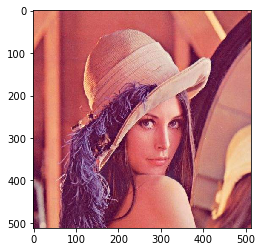

In [5]:
img = cv2.imread('lenna.jpeg')

plt.imshow(img[...,::-1])
plt.show()

# 卷积操作
图像中的卷积不需要翻转，严格来说叫做互相关 (cross-correlation)。

### 高斯卷积
`cv2.GaussianBlur`  
卷积核数值呈高斯分布，能够模糊图像。  
高斯滤波指定高斯核的大小，方差(variance)。  
方差越大，概率密度函数形状越粗，卷积核中心值和四周值的差异越小，图像越模糊。

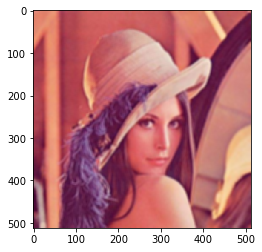

In [6]:
# Gaussian Kernel Effect
g_img = cv2.GaussianBlur(img, (7,7), 5)

plt.imshow(g_img[...,::-1])
plt.show()

一维高斯分布 (Gaussian distribution) / 正态分布 (Normal distribution)的概率密度函数：  
$$
h(x) = \frac{1}{{\sqrt {2\pi } \sigma }}e^\frac{ -(x-\mu)^2}{2{\sigma}^2}  
$$
二维高斯分布的[概率密度函数](https://baike.baidu.com/item/%E4%BA%8C%E7%BB%B4%E6%AD%A3%E6%80%81%E5%88%86%E5%B8%83/2951835?fr=aladdin)。图像中满足x, y变量相互独立的条件，在均值为0的情况下，可以得到高斯核的概率密度函数：  
$$
h(x,y) = \frac{1}{{2\pi  \sigma^2 }}e^\frac{ -(x^2+y^2)}{2{\sigma}^2} 
$$
在均值$\mu$为0的情况下，有:  
$$
h(x,y)=h(x) \cdot h(y)
$$  
为了验证这一点，可以输出cv2计算的高斯核。

In [7]:
kernel = cv2.getGaussianKernel(7, 5)  # 7: size, 5:variance
print(kernel)

[[0.12895603]
 [0.14251846]
 [0.15133131]
 [0.1543884 ]
 [0.15133131]
 [0.14251846]
 [0.12895603]]


由于高斯核是对称的，所以在生成高斯核时，只需要计算出一个向量 $\vec{v}$ (x, 1) :

$$
h(x,y)=h(x) \cdot h(y)=\vec{v} \cdot {\vec{v}}^T
$$

利用这一特性，可以加速高斯卷积运算。  

比如，用一个3×3大小的高斯核对一个6×6大小的图像进行卷积 *(pad=0, stride=1)*，直接相乘的运算量为：  
$$
(9m+8a)×16=144m+128a
$$
其中m代表单次乘法，a代表单次加法。  

如果将原图先按 $\vec{v}$ (3×1) 进行卷积，然后再按 ${\vec{v}}^T$ 进行卷积，运算量为  
$$
(3m+2a)×24+(3m+2a)×16=120m+80a
$$

可以看出运算量减少，并且图像越大，效果越明显。  

下面验证二者的等效性。

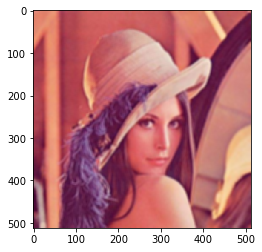

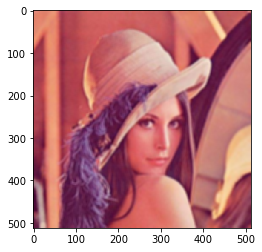

In [8]:
g1_img = cv2.GaussianBlur(img, (7,7), 5)

# first x, then y
# ori img, depth, kernelX, kernelY
g2_img = cv2.sepFilter2D(img, -1, kernel, kernel)

plt.imshow(g1_img[...,::-1])
plt.show()  


plt.imshow(g2_img[...,::-1])
plt.show()

注意，高斯kernel的属性： $h(x,y)=h(x) \cdot h(y)$ 使它可以用这种方法加速。  

## 图像导数
### 一阶导数
一阶导数是图像灰度值变化的趋势，定义为：  
$$
f'(x)=\frac{f(x+1)-f(x)}{(x+1)-x}=f(x+1)-f(x)
$$
#### 一阶导数的作用  
将图片中某一行像素值记为gray
$$
\begin{array}{c|lcr}
gray & 5 & 5 & 4 & 3 & 2 & 1 & 0 & 0 & 0 & 6 & 0 & 0 \\
\hline
f'   & 0 &-1 &-1 &-1 &-1 &-1 & 0 & 0 & 6 &-6 & 0 & \\
\end{array}
$$

连续的像素值 5 4 3 2 1 在图像上表示有一定宽度的边缘，应用一阶导数，对应的值全为-1，所以**一阶导数能产生一个比较粗的边缘**。

#### 一阶导数的kernel

实际应用中，一阶导数对应的核通常不连续，比如间隔一个：

一阶导数也叫Sobel算子，分为x方向和y方向，用于边缘检测：

$$
\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1 \\
\end{bmatrix}
$$

上面这个kernel能够显示 (提取) 水平直线 (x方向)。

$$
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 \\
\end{bmatrix}
$$

上面这个kernel能够显示 (提取) 竖直直线 (y方向)。

(512, 512, 3)


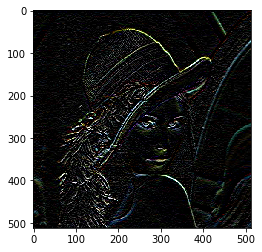

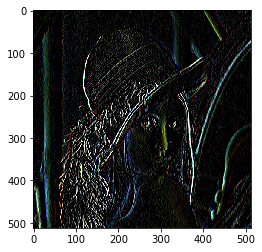

In [9]:
edge_x_kernel = np.array([[-1, -2, -1],
                          [0, 0, 0],
                          [1, 2, 1]], np.float32)
edge_y_kernel = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]], np.float32)

edge_x_img = cv2.filter2D(img, -1, kernel=edge_x_kernel)
edge_y_img = cv2.filter2D(img, -1, kernel=edge_y_kernel)


print(edge_x_img.shape)

# plt.figure(figsize=(10,10))
plt.imshow(edge_x_img)
plt.show()

# plt.figure(figsize=(10,10))
plt.imshow(edge_y_img)
plt.show()

参考[filter2D()](https://docs.opencv.org/3.4.6/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)，可以发现这个单通道的kernel是在每个通道上分别处理的。  

TODO：

[我的提问](https://trello.com/c/faitQAPY/256-%E5%85%B3%E4%BA%8Ecv2filter2d%E7%9A%84%E5%8F%82%E6%95%B0%E9%97%AE%E9%A2%98)

### 二阶导数：
在一阶导数的基础上可以得到二阶导数的定义：  
$$
\begin{aligned}
f''(x) & = f'(x+1) - f'(x) \\
       & = f(x+2) - f(x+1) - f(x+1) + f(x) \\
\end{aligned}
$$
也可以记作$f(x+1) + f(x-1) -2f(x)$.  
#### 二阶导数的作用  
$$
\begin{array}{c|lcr}
gray & 5 & 5 & 4 & 3 & 2 & 1 & 0 & 0 & 0 & 6 & 0 & 0 \\
\hline
f'   & 0 &-1 &-1 &-1 &-1 &-1 & 0 & 0 & 6 &-6 & 0 & \\
\hline
f''  &-1 & 0 & 0 & 0 & 0 & 1 & 0 & 6 &\mathbf{-12}& 6 &   &
\end{array}
$$
可以发现：
1. 一个比较细的边缘 0 6 0 在二阶导数中变成了 6 -12 6，说明二阶导数**增强了精细结构（对其敏感）**。  
2. 比较粗的边缘 5 4 3 2 1 在二阶导数中变成了 -1 0 0 0 0 1，即粗边边变成了两条细边，原来的细边 0 6 0 也变成了 6 -12 6，这叫做**双边效应**。  

#### 二阶导数的kernel
根据前面的推导，一维数据的二阶导数为：
$$
f''(x)=f(x+1) + f(x-1) -2f(x)
$$
可以将kernel记为：
$$
\begin{bmatrix}
1 & -2 & 1 \\
\end{bmatrix}
$$
则2-D图像上的二阶导数kernel是在X，Y方向上的叠加：
$$
\begin{bmatrix}
0 & 1 & 0 \\
1 & -4 &1 \\
0 & 1 & 0 \\
\end{bmatrix}
$$
这个核又叫Laplacian核，用这个kernel处理图像：  

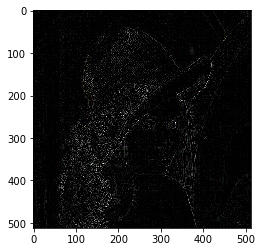

In [10]:
kernel_laplace = np.array([[0, 1, 0],
                          [1, -4, 1],
                          [0, 1, 0]], np.float32)
laplace_img = cv2.filter2D(img, -1, kernel=kernel_laplace)

plt.imshow(laplace_img)
plt.show()

二阶导数又叫Laplacian核，除了双边效果，还可以用来突出图像边缘:

$$
img_{sharpen} = img_{origin} + edge
$$

相当于用下面的核卷积图像：  

$$
\begin{bmatrix}
0 & 1 & 0 \\
1 & -3 &1 \\
0 & 1 & 0 \\
\end{bmatrix}
$$

注意，中心值是 **-3**.  

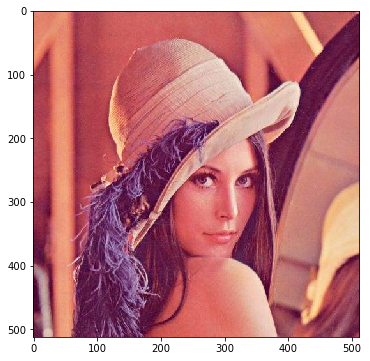

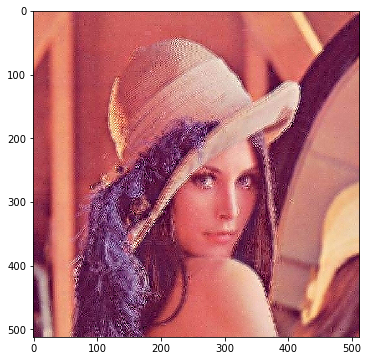

In [11]:
kernel_sharp = np.array([[0, 1, 0],
                          [1, -3, 1],
                          [0, 1, 0]], np.float32)
sharp_img = cv2.filter2D(img, -1, kernel=kernel_sharp)

plt.figure(figsize=(6,6))
plt.imshow(img[...,::-1])
plt.show()  

plt.figure(figsize=(6,6))
plt.imshow(sharp_img[...,::-1])
plt.show()  

可以发现处理之后边缘突出（双边效果），但图像好像变得更模糊了，如果想解决这个问题，只需要把laplace kernel取相反数，处理后和sharpen img相加，就可以在保留突出边缘的同时，让图像保持清晰。  

实际上相当于直接对原图用这样一个kernel进行卷积：

$$
\begin{bmatrix}
0 & -1 & 0 \\
-1 & 5 &-1 \\
0 & -1 & 0 \\
\end{bmatrix}
$$

这样可以保持中心值占比最大，下面对比两次sharp操作。  

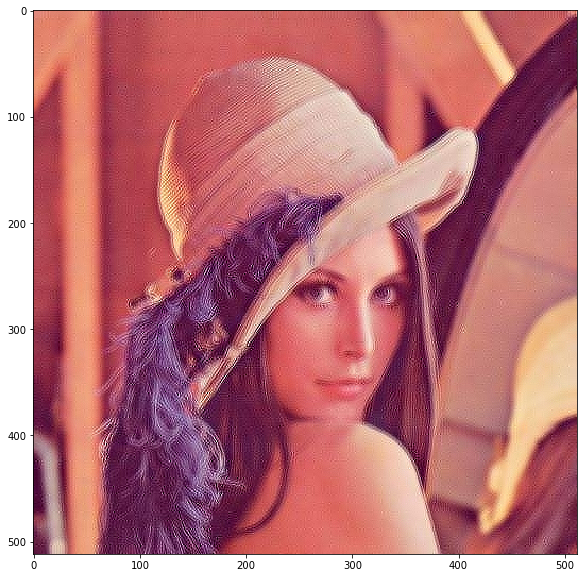

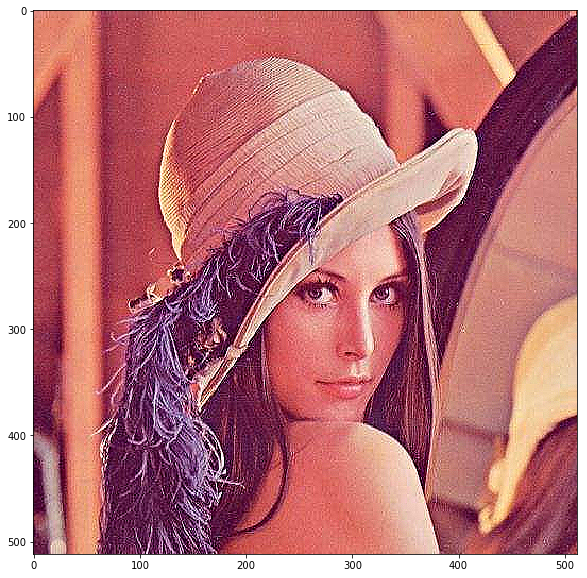

In [12]:
kernel_sharp2 = np.array([[0, -1, 0],
                          [-1, 5, -1],
                          [0, -1, 0]], np.float32)
sharp_img2 = cv2.filter2D(img, -1, kernel=kernel_sharp2)

plt.figure(figsize=(10,10))
plt.imshow(sharp_img[...,::-1])
plt.show()  

plt.figure(figsize=(10,10))
plt.imshow(sharp_img2[...,::-1])
plt.show()  

在保留突出边缘的同时，图像内容更清晰，优化之后的kernel往往用来用于图像锐化（sharpen）。  

下面这个kernel能够造成更“凶猛”的边缘效果，不仅考虑x-y方向上的梯度，同时考虑了对角线方向上的梯度：  

$$
\begin{bmatrix}
1 & 1 & 1 \\
1 &-8 & 1 \\
1 & 1 & 1 \\
\end{bmatrix}
$$

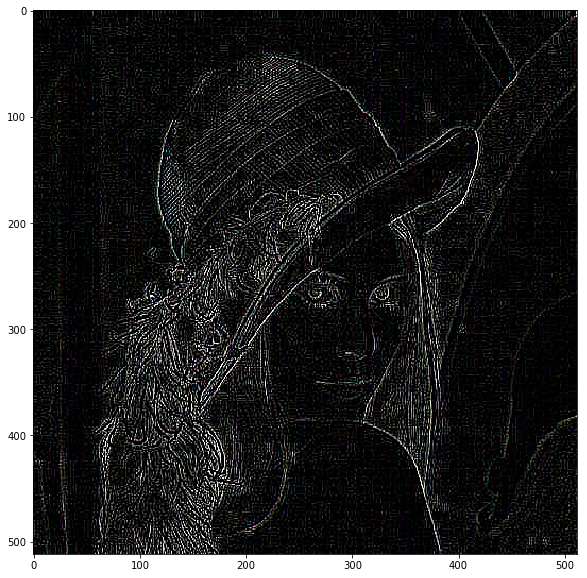

In [13]:
kernel3 = np.array([[1, 1, 1],
                    [1,-8, 1],
                    [1, 1, 1]], np.float32)
img_kernel3 = cv2.filter2D(img, -1, kernel=kernel3)

plt.figure(figsize=(10,10))
plt.imshow(img_kernel3[...,::-1])
plt.show()  

# Harris Corner Detector
参考资料：  
- [wiki](https://en.wikipedia.org/wiki/Harris_Corner_Detector)  
- [OpenCV](https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html) ☆

角点应该是该点对附近区域方差最大的点，所以，要使 $E(u,v)$ 最大:

$$
E(u,v) = \sum_{x,y} \underbrace{w(x,y)}_\text{window function} \, [\underbrace{I(x+u,y+v)}_\text{shifted intensity}-\underbrace{I(x,y)}_\text{intensity}]^2
$$

*Window function is either a rectangular window or gaussian window which gives weights to pixels underneath.*

对第二项进行泰勒展开，可以得到：

$$
E(u,v) \approx \begin{bmatrix} u & v \end{bmatrix} M \begin{bmatrix} u \\ v \end{bmatrix} \tag{*}\label{*}
$$
 
其中 $M$ 为：

$$
M = \sum_{x,y} w(x,y) \begin{bmatrix}I_x I_x & I_x I_y \\ I_x I_y & I_y I_y \end{bmatrix}
$$

*$I_x$  and $I_y$ are image derivatives in x and y directions respectively. (Sobel)*  

$\ref{*}$这种形式代表椭圆，$M$ 的两个特征值 $\lambda_1, \lambda_2$ 代表了椭圆的两个半轴，大小表示在x，y方向上变化的快慢，越大变化越快。$\lambda_1, \lambda_2$ 都很大的话，即可将该点判断为角点。

具体实现上，并不需要计算出 $\lambda_1, \lambda_2$ 的具体值，可以用 $R$ 来衡量它们的大小：

$$
R = det(M) - k(trace(M))^2
$$

通过 $R$ 还可以区分图像的 corner, edge, flat 区域，具体见[OpenCV](https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html)，其中有相关代码。  

[cv.cornerHarris()](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345)，参数有:  
- img - Input image, it should be grayscale and float32 type.
- blockSize - It is the size of neighbourhood considered for corner detection
- ksize - Aperture parameter of Sobel derivative used.
- k - Harris detector free parameter in the equation.

(480, 640)


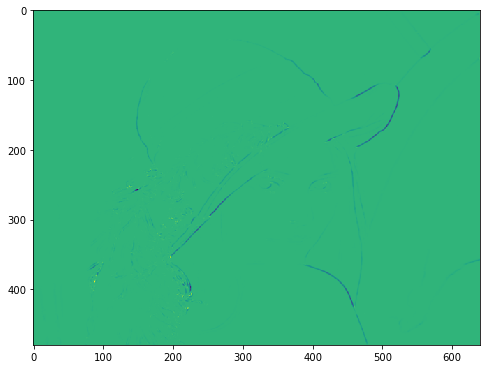

In [14]:
img2 = cv2.resize(img, (640, 480))
img_gray = np.float32(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY))

dst = cv2.cornerHarris(img_gray, 2, 3, 0.05)  # `cv2.cornerHarris` need gray

print(dst.shape)

plt.figure(figsize=(8,8))
plt.imshow(dst)
plt.show()  

并不能直观的当做一个图像看待，原因：  
- img_harris本质上是每个pixel对于Harris函数的响应值
进行相应修改：  

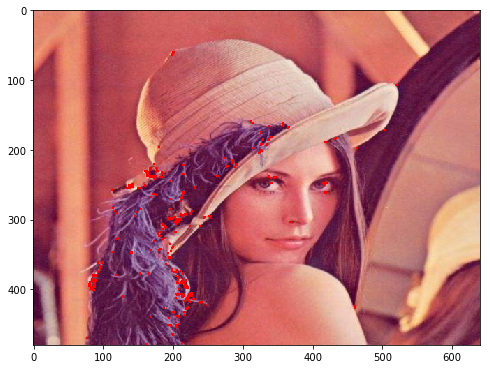

In [15]:
thres = 0.05 * np.max(dst)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img2[dst > thres] = [0, 0, 255]
plt.figure(figsize=(8,8))
plt.imshow(img2[...,::-1])
plt.show()  

# Feature Points
一个好的特征点应该能够克服 旋转变换，光照变化，尺度变化的问题，角点在尺度变化时，无法很好匹配。  
## SIFT (Scale Invariant Feature Transform)
### 1. Generate Scale-space: DoG (Different of Gaussian)  
利用多个高斯核，创造多个空间，对应多个尺度，形成图像金字塔。  
每个octave中的图模糊程度不同  
![octave](SIFT_img/octave.png)  
在每个octave中，相邻两张图做差，可以获取不同的边缘图像：  
![edge](SIFT_img/scale_edge.png)  
**这些边缘图组成了 DoG**
### 2. Scale-space Extrema Detection  
将每一点和相邻两张图的对应区域中的点 (29 - 1 个) 比较，选择极值点。  
![point_select](SIFT_img/point_select.png)
### 3. Accurate Keypoint Localization
点的再筛选。进行插值，求导求极值，作为新的选择点（更精准）。
### 4. Eliminating Edge Responses
选择阈值，进行抑制（噪音）操作。
### 5. Orientation Assignment
描述选择出来的关键点，对于每一个关键点，根据x,y上的梯度获得角度，赋予其一个方向。  
方向是根据角度直方图选择，可以选择不止一个方向。  
![hist](SIFT_img/hist.png)
### 6. Keypoint Descriptor
每一个关键点都有了方向，将关键点附近区域按方向旋转：  
![rota](SIFT_img/rota.png)  
以当前关键点为中心，再将区域划分（4×4=16个小区域），每个小区域里规定8个方向，再次使用角度直方图获取这8个方向上的值：  
![descriptor](SIFT_img/descriptor.png)  
所以，对于每一个关键点，可以获取（16×8=128）个值，这就是 descriptor， 可以描述一个关键点的SIFT信息, 将这个128维的向量归一化之后，就进一步去除了光照的影响。  

关于SIFT的更详细的内容，可以参考[这里](https://blog.csdn.net/gwplovekimi/article/details/80019589). 

(1053, 128)


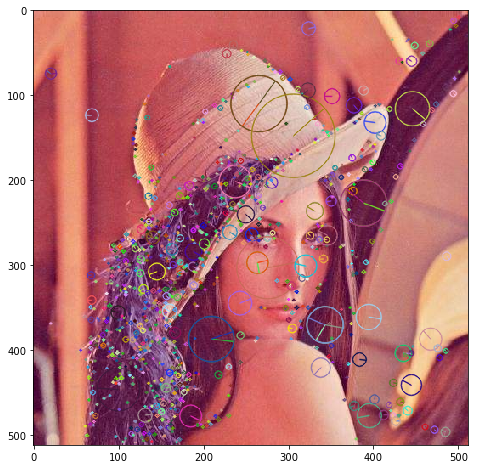

In [16]:
img = cv2.imread('lenna.jpeg')
# create sift class
sift = cv2.xfeatures2d.SIFT_create()
# detect SIFT
kp = sift.detect(img, None)   # None for mask
# compute SIFT descriptor
kp,des = sift.compute(img, kp)
print(des.shape)
img_sift= cv2.drawKeypoints(img, kp, outImage=np.array([]), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(8,8))
plt.imshow(img_sift[...,::-1])
plt.show()  

 

除了SIFT，SURF(由SIFT发展，速度更快)，Orb(slam)，HoG(detection方面应用较多)也经常应用。  

**匹配特征点的方法：RANSAC**  

# 总结
- 高斯核，一阶核，二阶核都有什么作用？下面几个核的效果有什么不同？

$$
\begin{bmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1 \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
0 & 1 & 0 \\
1 & -4 &1 \\
0 & 1 & 0 \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
0 & 1 & 0 \\
1 & -3 &1 \\
0 & 1 & 0 \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
0 & -1 & 0 \\
-1 & 5 &-1 \\
0 & -1 & 0 \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
1 & 1 & 1 \\
1 &-8 & 1 \\
1 & 1 & 1 \\
\end{bmatrix}
$$
- 高斯核为什么能够加速计算，如何加速计算？
- 写出3×3的一阶核和二阶核 (*Sobel Operator / Laplace Operator*)？
- Harris角点的流程？
- SIFT的流程？